In [1]:
import logging
import os
import re
from typing import Optional, List

import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, BatchSampler
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce
from skimage.color import label2rgb
from skimage.measure import regionprops_table


note that you need to make bug fix to diffusers v0.3.0

in ~/.local/lib/python3.9/site-packages/diffusers/models/unet_blocks.py you need to change out_channels parameter in DownEncoderBlock2D to make the unet work for >2 downsamples

out_channels=in_channels if add_downsample else out_channels,


In [2]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

#### load datasets

In [3]:
dataset_dir = '../data/pytorch_datasets/pdac_v5/'

In [4]:
def get_n_voxels(padded_voxel_idxs):
    idx = padded_voxel_idxs.flip((0,)).nonzero()[0].item()
    return len(padded_voxel_idxs[:-idx])

In [5]:
class DirectorySTDataset(Dataset):
    def __init__(self, directory, normalize=True):
        super().__init__()
        self.dir = directory
        self.fps = [os.path.join(self.dir, fp) for fp in os.listdir(self.dir) if fp[-3:]=='.pt']
        
        if normalize:
            self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)) # from HT397B1-H2 ffpe H&E image
        else:
            self.normalize = nn.Identity()
        
    def __len__(self):
        return len(self.fps)

    def __getitem__(self, idx):
        
        fp = self.fps[idx]
        obj = torch.load(fp)
        img = TF.convert_image_dtype(obj['he'], dtype=torch.float32)

        return {
            'he': self.normalize(img),
            'he_orig': img,
            'masks': obj['masks'],
            'voxel_idxs': obj['voxel_idxs'],
            'exp': obj['exp'],
            'exp_tiles': obj['exp_tiles'],
            'n_voxels': get_n_voxels(obj['voxel_idxs']),
            'b': torch.tensor([1.])
        }

In [6]:
train_ds = DirectorySTDataset(os.path.join(dataset_dir, 'train'))
len(train_ds)

7880

In [7]:
val_ds = DirectorySTDataset(os.path.join(dataset_dir, 'val'))
len(val_ds)

3234

In [8]:
train_adata = sc.read_h5ad(os.path.join(dataset_dir, 'train', 'adata.h5ad'))
train_adata

AnnData object with n_obs × n_vars = 3940 × 2002
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
val_adata = sc.read_h5ad(os.path.join(dataset_dir, 'val', 'adata.h5ad'))
val_adata

AnnData object with n_obs × n_vars = 3234 × 2002
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [10]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [11]:
%%time
batch = next(iter(train_dl))

CPU times: user 1min 55s, sys: 1.09 s, total: 1min 56s
Wall time: 10.9 s


###### data inspection

In [23]:
def cte(padded_exp, masks, n_voxels):
    tile = torch.zeros((masks.shape[1], masks.shape[2], padded_exp.shape[1]))
    for exp, m in list(zip(padded_exp, masks))[:n_voxels]:
        tile[m==1] = exp
    return tile

In [24]:
i = 166
# i = 144

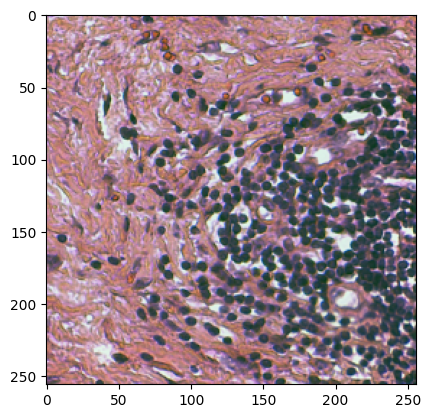

In [25]:
img = rearrange(train_ds[i]['he'], 'c h w -> h w c')
img -= img.min()
img /= img.max()
plt.imshow(img)

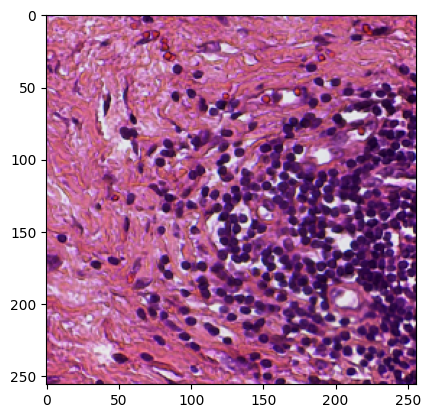

In [26]:
img = rearrange(train_ds[i]['he_orig'], 'c h w -> h w c')
plt.imshow(img)

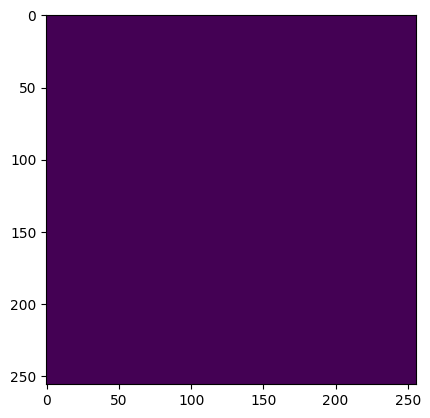

In [42]:
plt.imshow(torch.sum(train_ds[i]['masks'], dim=0))

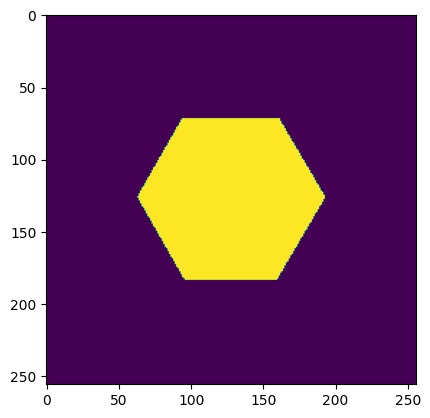

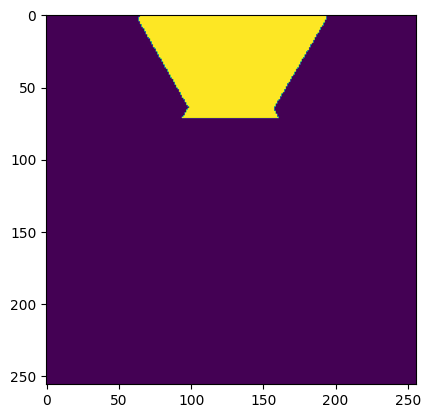

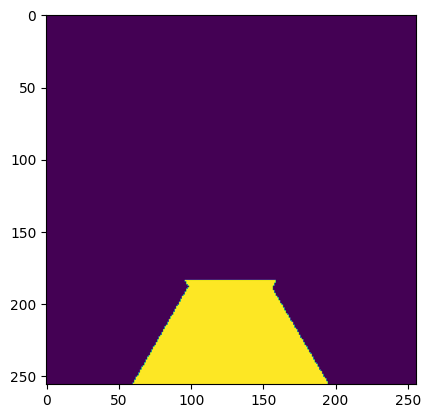

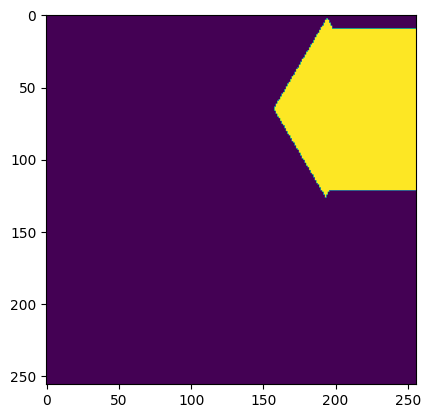

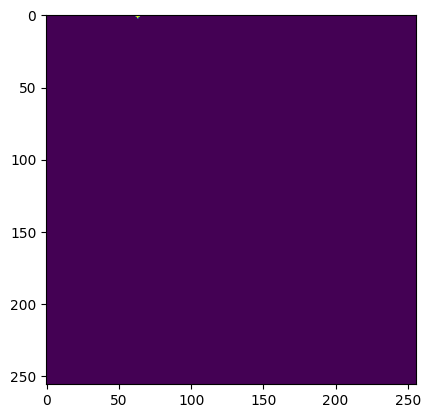

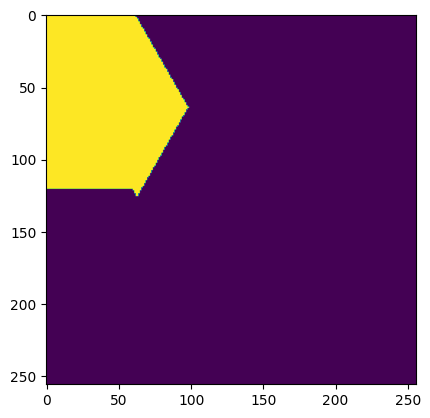

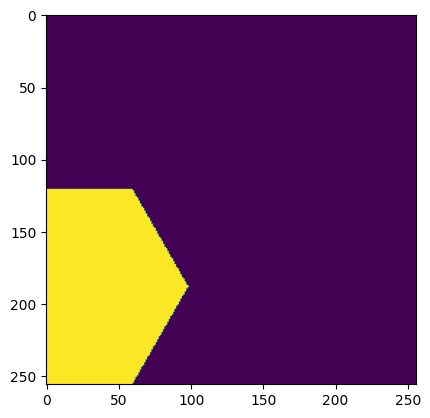

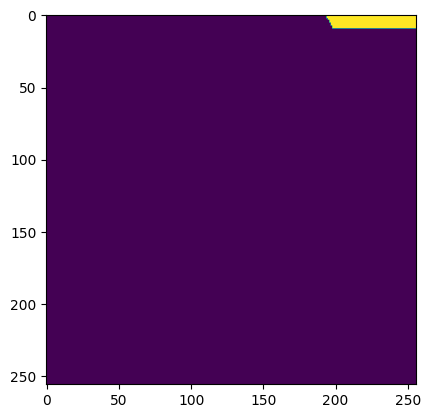

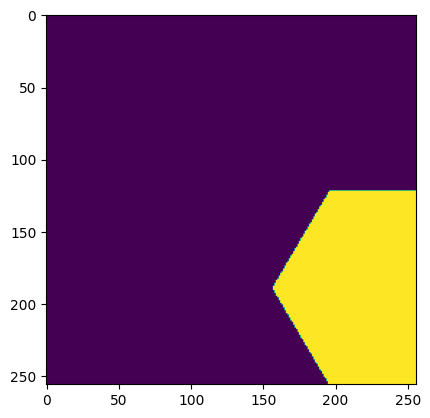

In [43]:
for j in range(train_ds[i]['n_voxels']):
    plt.imshow(train_ds[i]['masks'][j])
    plt.show()

In [44]:
torch.sum(train_ds[i]['masks'], dim=(-1, -2))

tensor([10970,  6718,  6796,  9235,     7,  9828, 10685,   602, 10695,     0,
            0,     0,     0,     0,     0,     0])

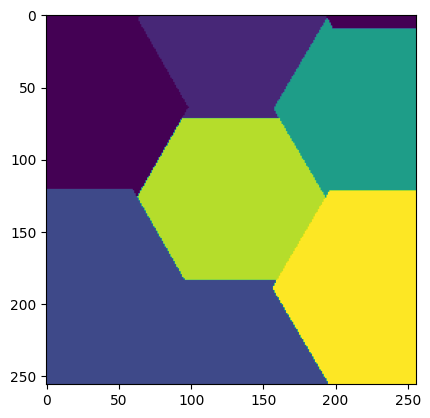

In [45]:
gene = 'IL7R'
recon = cte(train_ds[i]['exp'], train_ds[i]['masks'], train_ds[i]['n_voxels'])
plt.imshow(recon[:, :, train_adata.var.index.to_list().index(gene)])

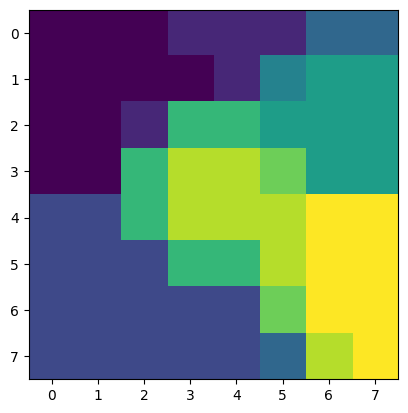

In [49]:
plt.imshow(train_ds[i]['exp_tiles'][:, :, train_adata.var.index.to_list().index(gene)])

In [46]:
train_ds[i]['exp']

tensor([[0., 1., 0.,  ..., 2., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [47]:
train_ds[i]['voxel_idxs']

tensor([ 479, 1356, 2060, 2132, 2632, 2886, 2900, 3900, 3910,    0,    0,    0,
           0,    0,    0,    0], dtype=torch.int16)

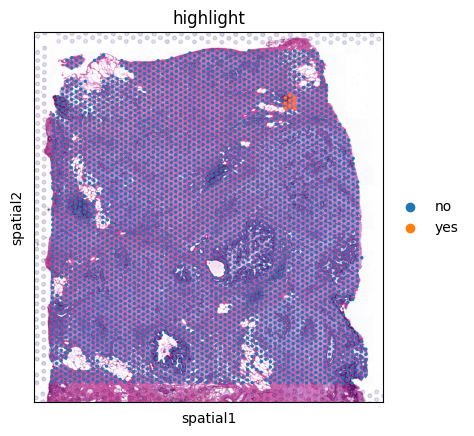

In [48]:
pool = set(train_ds[i]['voxel_idxs'][:train_ds[i]['n_voxels']].detach().numpy())
train_adata.obs['highlight'] = ['yes' if i in pool else 'no'
                               for i in train_adata.obs['spot_index']]
sc.pl.spatial(train_adata, color='highlight')

In [62]:
i = 1

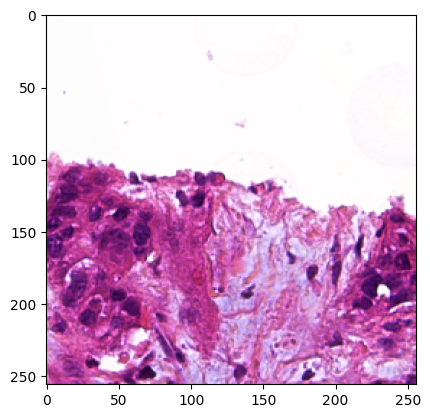

In [63]:
img = rearrange(val_ds[i]['he_orig'], 'c h w -> h w c')
plt.imshow(img)

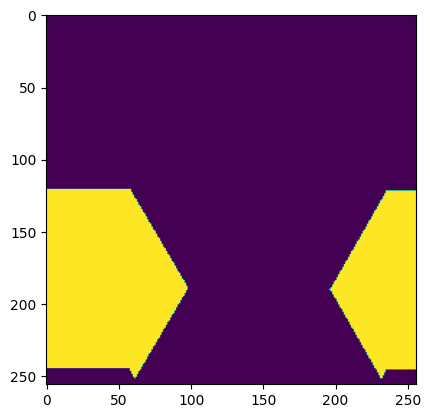

In [64]:
gene = 'EPCAM'
recon = cte(val_ds[i]['exp'], val_ds[i]['masks'], val_ds[i]['n_voxels'])
plt.imshow(recon[:, :, val_adata.var.index.to_list().index(gene)])

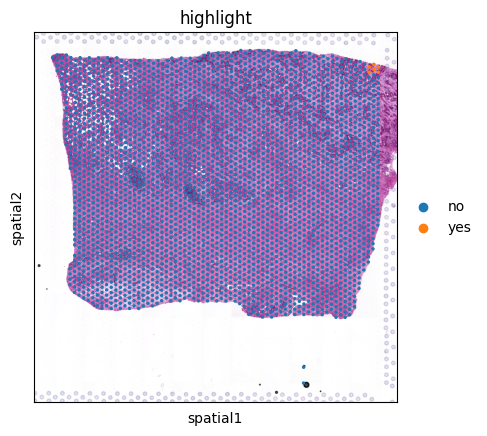

In [65]:
pool = set(val_ds[i]['voxel_idxs'][:val_ds[i]['n_voxels']].detach().numpy())
val_adata.obs['highlight'] = ['yes' if i in pool else 'no'
                               for i in val_adata.obs['spot_index']]
sc.pl.spatial(val_adata, color='highlight')

#### model

In [56]:
# !pip install git+https://github.com/huggingface/diffusers.git@e72f1a8a71ba0d9dab44a09178e7e532690b56f1

In [12]:
from typing import Optional, Tuple, Union
from diffusers.models.unet_blocks import UNetMidBlock2D, get_down_block, get_up_block
from diffusers.models.vae import Encoder, Decoder, DiagonalGaussianDistribution, AutoencoderKLOutput, DecoderOutput

In [13]:
import diffusers
diffusers.__version__

'0.4.0.dev0'

In [14]:

"""modified from diffusers kl autoencoder"""
class AutoencoderKL(nn.Module):
    r"""Variational Autoencoder (VAE) model with KL loss from the paper Auto-Encoding Variational Bayes by Diederik P. Kingma
    and Max Welling.
    This model inherits from [`ModelMixin`]. Check the superclass documentation for the generic methods the library
    implements for all the model (such as downloading or saving, etc.)
    Parameters:
        in_channels (int, *optional*, defaults to 3): Number of channels in the input image.
        out_channels (int,  *optional*, defaults to 3): Number of channels in the output.
        down_block_types (`Tuple[str]`, *optional*, defaults to :
            obj:`("DownEncoderBlock2D",)`): Tuple of downsample block types.
        up_block_types (`Tuple[str]`, *optional*, defaults to :
            obj:`("UpDecoderBlock2D",)`): Tuple of upsample block types.
        block_out_channels (`Tuple[int]`, *optional*, defaults to :
            obj:`(64,)`): Tuple of block output channels.
        act_fn (`str`, *optional*, defaults to `"silu"`): The activation function to use.
        latent_channels (`int`, *optional*, defaults to `4`): Number of channels in the latent space.
        sample_size (`int`, *optional*, defaults to `32`): TODO
    """
    def __init__(
        self,
        genes,
        tile_resolution = 16,
        n_metagenes = 20,
        in_channels = 3,
        out_channels = 64,
        down_block_types = ("DownEncoderBlock2D",),
        up_block_types = ("UpDecoderBlock2D",),
        block_out_channels = (64,),
        layers_per_block = 1,
        act_fn = "silu",
        latent_channels = 4,
        norm_num_groups = 32,
        sample_size = 32,
        he_scaler = .1,
        kl_scaler = .001,
        exp_scaler = 1.
    ):
        super().__init__()
        
        self.genes = genes
        self.n_genes = len(genes)

        
        self.he_scaler = he_scaler
        self.kl_scaler = kl_scaler
        self.exp_scaler = exp_scaler
        
        # pass init params to Encoder
        self.encoder = Encoder(
            in_channels=in_channels,
            out_channels=latent_channels,
            down_block_types=down_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
            norm_num_groups=norm_num_groups,
            double_z=True,
        )

        # pass init params to Decoder
        self.decoder = Decoder(
            in_channels=latent_channels,
            out_channels=out_channels,
            up_block_types=up_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            norm_num_groups=norm_num_groups,
            act_fn=act_fn,
        )

        self.quant_conv = torch.nn.Conv2d(2 * latent_channels, 2 * latent_channels, 1)
        self.post_quant_conv = torch.nn.Conv2d(latent_channels, latent_channels, 1)
        
        self.n_metagenes = n_metagenes
        self.tile_resolution = tile_resolution
        self.metagenes = torch.nn.Parameter(torch.rand(self.n_metagenes, self.n_genes))
        self.scale_factors = torch.nn.Parameter(torch.rand(self.n_genes))
        self.p = torch.nn.Parameter(torch.rand(self.n_genes))
        
        self.decoder_out_channels = out_channels
        self.post_decode_he = torch.nn.Conv2d(out_channels, 3, 1)
        self.post_decode_exp = torch.nn.Conv2d(out_channels, self.n_metagenes, 1)
        
        self.he_loss = torch.nn.MSELoss()

    def encode(self, x: torch.FloatTensor, return_dict: bool = True) -> AutoencoderKLOutput:
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)

        if not return_dict:
            return (posterior,)

        return AutoencoderKLOutput(latent_dist=posterior)

    def decode(self, z: torch.FloatTensor, return_dict: bool = True) -> Union[DecoderOutput, torch.FloatTensor]:
        z = self.post_quant_conv(z)
        dec = self.decoder(z)

        if not return_dict:
            return (dec,)

        return DecoderOutput(sample=dec)
    
    def calculate_loss(self, he_true, exp_true, result):
        exp_loss = torch.mean(-result['nb'].log_prob(exp_true))
        
        kl_loss = torch.mean(result['posterior'].kl())
        
        he_loss = torch.mean(self.he_loss(he_true, result['he']))
        
        return {
            'overall_loss': exp_loss * self.exp_scaler + kl_loss * self.kl_scaler + he_loss * self.he_scaler,
            'exp_loss': exp_loss,
            'kl_loss': kl_loss,
            'he_loss': he_loss
        }
    
    def reconstruct_expression(self, dec, reduce_to_tile=True):
        x = self.post_decode_exp(dec)
        
        if reduce_to_tile:
            x = reduce(x, 'b c (h1 h2) (w1 w2) -> b c h1 w1', 'sum', h2=self.tile_resolution, w2=self.tile_resolution)
            
        x = rearrange(x, 'b c h w -> b h w c')
        
        r = x @ self.metagenes
        r *= self.scale_factors
        r = F.softplus(r)
        r += .00000001
        
        p = torch.sigmoid(self.p)
        p = rearrange(p, 'c -> 1 1 1 c')
        
        nb = torch.distributions.NegativeBinomial(r, p)
        
        return {
            'r': r,
            'p': p,
            'exp': nb.mean,
            'nb': nb
        }
    
    def reconstruct_he(self, dec):
        he = self.post_decode_he(dec)
        return he

    def forward(
        self,
        sample: torch.FloatTensor,
        reduce_to_tile = True,
        sample_posterior: bool = False,
        return_dict: bool = True,
        generator: Optional[torch.Generator] = None,
    ) -> Union[DecoderOutput, torch.FloatTensor]:
        r"""
        Args:
            sample (`torch.FloatTensor`): Input sample.
            sample_posterior (`bool`, *optional*, defaults to `False`):
                Whether to sample from the posterior.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`DecoderOutput`] instead of a plain tuple.
        """
        x = sample
        posterior = self.encode(x).latent_dist
        if sample_posterior:
            z = posterior.sample(generator=generator)
        else:
            z = posterior.mode()
        
        dec = self.decode(z).sample
        

        he = self.reconstruct_he(dec)
        
        exp_result = self.reconstruct_expression(dec, reduce_to_tile=reduce_to_tile)
        
        result = {
            'posterior': posterior,
            'z': z,
            'dec': dec,
            'he': he,
        }
        result.update(exp_result)

        return result

In [15]:
"""
modified from https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31
"""
class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet34',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=5,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=False, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x


class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [16]:
class UnetBased(nn.Module):
    def __init__(
        self,
        genes,
        tile_resolution = 16,
        n_metagenes = 20,
        in_channels = 3,
        out_channels = 64,
        decoder_channels = (128, 64, 32, 16, 8),
        he_scaler = .1,
        kl_scaler = .001,
        exp_scaler = 1.
    ):
        super().__init__()
        
        self.genes = genes
        self.n_genes = len(genes)

        
        self.he_scaler = he_scaler
        self.kl_scaler = kl_scaler
        self.exp_scaler = exp_scaler
        
        self.unet = Unet(backbone='resnet34',
                         decoder_channels=decoder_channels,
                         in_chans=in_channels,
                         num_classes=out_channels)

        # latent mu and var
        self.latent_mu = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1)
        self.latent_var = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1)
        
        self.n_metagenes = n_metagenes
        self.tile_resolution = tile_resolution
        self.metagenes = torch.nn.Parameter(torch.rand(self.n_metagenes, self.n_genes))
        self.scale_factors = torch.nn.Parameter(torch.rand(self.n_genes))
        self.p = torch.nn.Parameter(torch.rand(self.n_genes))
        
        self.post_decode_he = torch.nn.Conv2d(out_channels, 3, 1)
        self.post_decode_exp = torch.nn.Conv2d(out_channels, self.n_metagenes, 1)
        
        self.he_loss = torch.nn.MSELoss()
        
    def _kl_divergence(self, z, mu, std):
        # lightning imp.
        # Monte carlo KL divergence
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)

        return kl

    def encode(self, x, use_means=False):
        x_encoded = self.unet(x)
        mu, log_var = self.latent_mu(x_encoded), self.latent_var(x_encoded)
        
        # sample z from parameterized distributions
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        # get our latent
        if use_means:
            z = mu
        else:
            z = q.rsample()

        return z, mu, std
    
    def calculate_loss(self, he_true, exp_true, result):
        exp_loss = torch.mean(-result['nb'].log_prob(exp_true))
        
        kl_loss = torch.mean(self._kl_divergence(result['z'], result['z_mu'], result['z_std']))
        
        he_loss = torch.mean(self.he_loss(he_true, result['he']))
        
        return {
            'overall_loss': exp_loss * self.exp_scaler + kl_loss * self.kl_scaler + he_loss * self.he_scaler,
            'exp_loss': exp_loss,
            'kl_loss': kl_loss,
            'he_loss': he_loss
        }
    
    def reconstruct_expression(self, dec, reduce_to_tile=True):
        x = self.post_decode_exp(dec)
        
        if reduce_to_tile:
            x = reduce(x, 'b c (h1 h2) (w1 w2) -> b c h1 w1', 'sum', h2=self.tile_resolution, w2=self.tile_resolution)
            
        x = rearrange(x, 'b c h w -> b h w c')
        
        g = x @ self.metagenes
#         r = g * self.scale_factors
        r = F.softplus(g)
        r += .00000001
        
        p = torch.sigmoid(self.p)
        p = rearrange(p, 'c -> 1 1 1 c')
        
        nb = torch.distributions.NegativeBinomial(r, p)
        
        return {
            'r': r,
            'p': p,
            'exp': nb.mean,
            'nb': nb
        }
    
    def reconstruct_he(self, dec):
        he = self.post_decode_he(dec)
        return he

    def forward(self, sample, reduce_to_tile=True, use_means=False):
        x = sample
        z, z_mu, z_std = self.encode(x, use_means=use_means)

        he = self.reconstruct_he(z)
        
        exp_result = self.reconstruct_expression(z, reduce_to_tile=reduce_to_tile)
        
        result = {
            'z': z,
            'z_mu': z_mu,
            'z_std': z_std,
            'he': he,
            'g': g,
        }
        result.update(exp_result)

        return result

In [17]:

def log_intermediates(logger, batch, result, plot_genes, model_genes, n_samples=16, result_full_res=None):
    img = batch['he'][:n_samples]
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key="he groundtruth",
        images=[img],
        caption=['he tile 2x']
    )
    
    img = result['he'][:n_samples] # (b c h w)
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key="he recon",
        images=[img],
        caption=['he tile recon']
    )

    recon = batch['exp_tiles'][:n_samples].to(torch.float16)
    recon = recon[:, :, :, [True if g in plot_genes else False for g in model_genes]]
    recon -= recon.min()
    recon /= recon.max()
    recon = torch.tensor(rearrange(recon, 'b h w c -> c b 1 h w'))
    logger.log_image(
        key=f"exp groundtruth",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )

    recon = result['exp'][:n_samples].to(torch.float16)
    recon = recon[:, :, :, [True if g in plot_genes else False for g in model_genes]]
    recon -= recon.min()
    recon /= recon.max()
    recon = torch.tensor(rearrange(recon, 'b h w c -> c b 1 h w'))
    logger.log_image(
        key=f"exp reconstruction",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )
    
    if result_full_res is not None:
        model_recon = result_full_res['exp'][:n_samples]
        recon = model_recon[:, :, :, [True if g in plot_genes else False for g in model_genes]]
        recon = torch.tensor(rearrange(recon, 'b h w c -> c b 1 h w'))
        logger.log_image(
            key=f"full res exp reconstruction",
            images=[img for img in recon],
            caption=[g for g in plot_genes]
        )
    
    

In [18]:
class xFuseLightning(pl.LightningModule):
    def __init__(self, autokl, lr=1e-3, n_samples=16, plot_genes=['IL7R', 'KRT18', 'BGN', 'PECAM1']):
        super().__init__()
        
        self.autokl = autokl
        self.lr = lr
        self.plot_genes = plot_genes
        self.n_samples = n_samples
        
        self.save_hyperparameters(ignore=['autokl'])

    def training_step(self, batch, batch_idx):
        x, b, masks, voxel_idxs, exp, exp_tiles = batch['he'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['exp'], batch['exp_tiles']
        result = self.autokl(x)
        losses = self.autokl.calculate_loss(x, exp_tiles, result)
        losses = {f'train/{k}':v for k, v in losses.items()}
        self.log_dict(losses, on_step=False, on_epoch=True, prog_bar=True)
        losses['loss'] = losses['train/overall_loss']
        
        return losses
    
    def validation_step(self, batch, batch_idx):
        x, b, masks, voxel_idxs, exp, exp_tiles = batch['he'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['exp'], batch['exp_tiles']
        result = self.autokl(x)
        losses = self.autokl.calculate_loss(x, exp_tiles, result)
        losses = {f'val/{k}':v for k, v in losses.items()}
        self.log_dict(losses, on_step=False, on_epoch=True, prog_bar=True)
        
        if batch_idx == 0:
#             result_full_res = result = self.autokl(x, reduce_to_tile=False)
            result_full_res = None
            log_intermediates(self.logger, batch, result, self.plot_genes, self.autokl.genes,
                              n_samples=self.n_samples, result_full_res=result_full_res)
        
        return losses

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    
    

###### test forwards

In [24]:
batch = next(iter(train_dl))
x, b, masks, voxel_idxs, exp, exp_tiles = batch['he'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['exp'], batch['exp_tiles']


In [25]:
# autokl = AutoencoderKL(
#     train_adata.shape[1],
#     tile_resolution=32,
#     n_metagenes=20,
#     in_channels=3,
#     out_channels=64,
#     down_block_types=["DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D"],
#     up_block_types=["UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D"],
#     block_out_channels=[8, 16, 32, 64],
#     norm_num_groups=8,
#     latent_channels=4,
# )

In [26]:
autokl = UnetBased(
    train_adata.var.index.to_list(),
    tile_resolution=32,
    n_metagenes=20,
    in_channels=3,
    out_channels=64,
    
)

In [27]:
result = autokl(x)

torch.Size([64, 64, 256, 256])


In [21]:
result.keys()

dict_keys(['posterior', 'z', 'dec', 'he', 'r', 'p', 'exp', 'nb'])

In [22]:
result['exp'].shape

torch.Size([16, 8, 8, 2002])

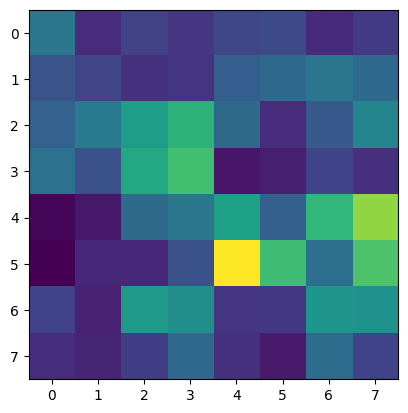

In [23]:
plt.imshow(result['exp'][0, :, :, 10].detach().numpy())

In [24]:
losses = autokl.calculate_loss(x, exp_tiles, result)

In [25]:
losses

{'overall_loss': tensor(290.0861, grad_fn=<AddBackward0>),
 'exp_loss': tensor(284.1591, grad_fn=<MeanBackward0>),
 'kl_loss': tensor(5811.6011, grad_fn=<MeanBackward0>),
 'he_loss': tensor(1.1540, grad_fn=<MeanBackward0>)}

#### training loop

In [19]:
project = 'unet_based'
log_dir = '/scratch1/fs1/dinglab/estorrs/deep-spatial-genomics/logs'

In [20]:
from pytorch_lightning.loggers import WandbLogger
logger = WandbLogger(project=project, save_dir=log_dir)

In [21]:
# wandb.finish()

In [22]:
config = {
    'n_genes': train_adata.shape[1],
    'genes': train_adata.var.index.to_numpy(),
    'n_covariates': 1,
    'n_metagenes': 20,
    'latent_dim': 64,
    'tile_resolution': 32,
    'encoder': {
        'model': 'unet',
        'in_channels': 3,
        'decoder_channels': (128, 64, 32, 16, 8)
#         'down_block_types': ["DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D",],
#         'up_block_types': ["UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D",],
#         'block_out_channels': [16, 32, 64, 128],
#         'in_channels': 3,
#         'layers_per_block': 1,
#         'act_fn': 'silu',
#         'latent_channels': 4,
#         'norm_num_groups': 16,
        
    },
    'kl_scalers': {
        'exp_scaler': 1.,
        'kl_scaler': .0001,
        'he_scaler': .1,
    },
    'training': {
        'train_samples': ['HT270P1-S1H1U1'],
        'val_samples': ['HT264P1-S1H2U1'],
        'log_n_samples': 16,
        'max_epochs': 1000,
        'check_val_every_n_epoch': 1,
        'log_every_n_steps': 1,
        'accelerator': 'gpu',
        'devices': 1,
        'limit_train_batches': 100,
        'limit_val_batches': 1,
        'lr': 5e-4,
        'batch_size': batch_size,
        'precision': 32
    },
}
logger.experiment.config.update(config)

In [23]:
# autokl = AutoencoderKL(
#     config['genes'],
#     tile_resolution=config['tile_resolution'],
#     n_metagenes=config['n_metagenes'],
#     in_channels=config['encoder']['in_channels'],
#     out_channels=config['latent_dim'],
#     down_block_types=config['encoder']['down_block_types'],
#     up_block_types=config['encoder']['up_block_types'],
#     block_out_channels=config['encoder']['block_out_channels'],
#     layers_per_block=config['encoder']['layers_per_block'],
#     act_fn=config['encoder']['act_fn'],
#     latent_channels=config['encoder']['latent_channels'],
#     norm_num_groups=config['encoder']['norm_num_groups'],
#     he_scaler=config['kl_scalers']['he_scaler'],
#     kl_scaler=config['kl_scalers']['kl_scaler'],
#     exp_scaler=config['kl_scalers']['exp_scaler'],
# )
autokl = UnetBased(
    config['genes'],
    tile_resolution=config['tile_resolution'],
    n_metagenes=config['n_metagenes'],
    in_channels=config['encoder']['in_channels'],
    out_channels=config['latent_dim'],
    decoder_channels=config['encoder']['decoder_channels'],
    he_scaler=config['kl_scalers']['he_scaler'],
    kl_scaler=config['kl_scalers']['kl_scaler'],
    exp_scaler=config['kl_scalers']['exp_scaler'],
)
model = xFuseLightning(autokl, lr=config['training']['lr'], n_samples=config['training']['log_n_samples'])

In [24]:
trainer = pl.Trainer(
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    check_val_every_n_epoch=config['training']['check_val_every_n_epoch'],
    enable_checkpointing=False,
    limit_val_batches=config['training']['limit_val_batches'],
    limit_train_batches=config['training']['limit_train_batches'],
    log_every_n_steps=config['training']['log_every_n_steps'],
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [25]:
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name   | Type      | Params
-------------------------------------
0 | autokl | UnetBased | 22.6 M
-------------------------------------
22.6 M    Trainable params
0         Non-trainable params
22.6 M    Total params
90.482    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/tmp/844953.tmpdir/ipykernel_12197/2555231550.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon = torch.tensor(rearrange(recon, 'b h w c -> c b 1 h w'))
/tmp/844953.tmpdir/ipykernel_12197/2555231550.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon = torch.tensor(rearrange(recon, 'b h w c

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
metagenes = model.autokl.metagenes.detach().cpu().numpy()
metagenes = pd.DataFrame(data=metagenes, columns=model.autokl.genes, index=np.arange(metagenes.shape[0]))
metagenes

,ISG15,MMP23B,PLCH2,ARHGEF16,ACOT7,TAS1R1,ERRFI1,RBP7,ANGPTL7,DISP3,...,MTMR1,MAGEA10,GABRQ,CSAG3,BGN,SRPK3,L1CAM,ARHGAP4,OPN1LW,AMELY
0,0.408822,0.376744,0.385762,1.152132,0.363286,0.375317,0.444990,0.254853,0.346881,0.457856,...,0.713537,0.624328,0.147375,0.315438,0.409614,0.457589,0.256923,-0.124293,0.221220,0.099828
1,0.315872,0.581778,0.470201,0.091142,0.612064,1.072080,0.450282,0.378512,0.782936,0.856367,...,0.550574,0.726997,0.742166,1.012154,0.081274,0.345412,0.683887,-0.207047,1.183067,0.925887
2,0.338109,0.773406,0.326985,0.750660,0.087993,0.042676,0.485000,0.550059,0.503692,0.128566,...,0.803215,0.075383,0.590187,0.679617,0.697983,0.326827,0.241561,0.239285,-0.002465,0.681307
3,0.724427,0.722422,0.163693,0.081474,0.672261,1.220819,-0.056837,0.277075,0.875609,0.199696,...,0.205880,0.432934,1.057414,0.843701,0.519172,0.903908,0.385155,0.000067,0.711413,0.677944
4,0.198180,-0.399510,0.332040,0.758985,0.354104,0.496734,0.226380,0.480895,0.611487,0.723867,...,0.731997,0.700166,0.697262,0.430287,0.071975,0.729454,0.453087,0.376947,0.570306,0.772082
5,0.602976,0.343723,0.812695,0.149650,0.617164,0.551756,0.310010,0.657727,0.390453,0.479278,...,0.673996,0.133224,0.845381,0.300577,0.738412,0.727464,0.475220,0.447203,0.591484,0.335091
6,0.290495,-0.123757,0.436480,0.369003,0.078795,0.921877,0.051915,0.599852,0.647129,0.423129,...,0.511293,0.068804,0.325444,0.819924,-0.068610,0.548865,0.257622,0.594579,0.869798,0.809483
7,0.444023,-0.233011,0.823077,0.527287,0.491790,0.358444,0.434294,0.341965,0.491022,0.675140,...,0.280342,0.612537,0.384184,1.018652,0.220539,0.428746,0.162555,0.073991,0.384347,0.401638
8,0.092587,0.081388,0.485494,0.705818,0.369152,0.599215,0.460231,0.112475,0.317921,0.424621,...,0.610649,-0.002606,0.469077,0.110228,0.462274,0.459050,0.843231,0.381006,0.474345,0.792551
9,0.221964,0.996437,0.531116,0.835259,0.311569,0.515066,0.873398,0.465098,0.662728,0.405180,...,0.664638,0.457554,0.405434,0.408405,0.252010,0.016235,0.314533,0.446665,0.483613,0.108046


/miniconda/lib/python3.9/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


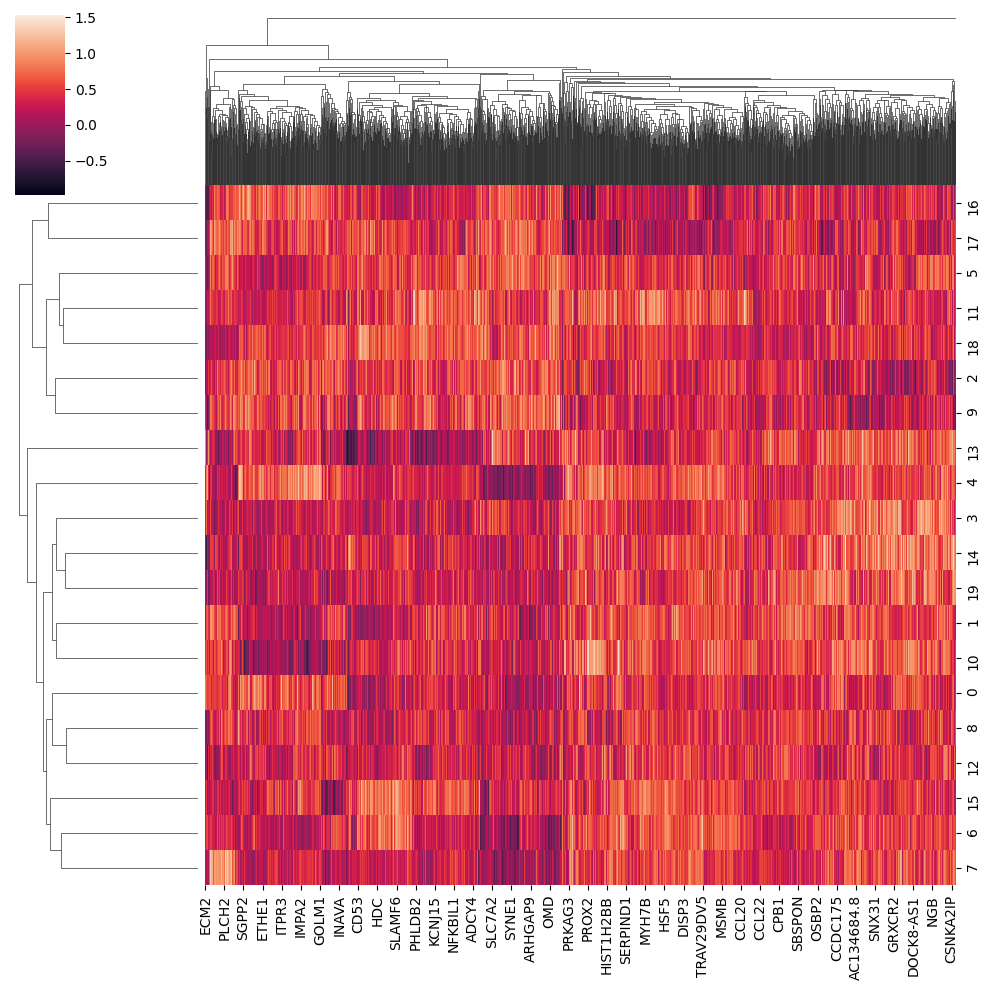

In [33]:
import seaborn as sns
sns.clustermap(data=metagenes)

In [35]:
batch = next(iter(train_dl))
x, b, masks, voxel_idxs, exp, exp_tiles = batch['he'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['exp'], batch['exp_tiles']


In [36]:
with torch.no_grad():
    result = autokl(x)

#### apply directly to H&E